---
title: "Financial Statistics Coursework"
subtitle: "Imperial College London - Business School"
author: 
  - name: "Rodolphe Lajugie"
  - name: "Kevin Aoun"
  - name: "Rong Guan"
  - name: "Huan Zhang"
  - name: "Diego Sanchez Loarte"
date: "November 2025"
format: pdf
fontsize: 12pt
geometry: margin=1in
titlepage: true
titlepage-geometry: "top=2cm, bottom=2cm, left=2cm, right=2cm"
---
\newpage
\tableofcontents
\newpage

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
from scipy import stats
import matplotlib.pyplot as plt

# Question 1

## Model 1: Simple CAPM Regression

### Manual Computation 

$$ r_{it} - r_{ft} = \alpha + \beta (r_{Mt} - r_{ft}) + u_{t} $$

Assuming that Gauss Markov conditions hold, we can compute the OLS estimator. <br>

We know that $\hat{\beta} = (X'X)^{-1}X'y$ <br>
Where $X$ is the $T\times2$ regressors matrix and y the response variable.

In [2]:
df = pd.read_excel('../data/data_coursework_Q3.xlsx')

In [3]:
df = pd.read_excel('../data/data_coursework1_Q1.xlsx')
df = df[['year_', 'month_', 'date_', '1-month Tbill', 'SP500', 'IBM']]

# Calculate returns
df['SP500_ret'] = df['SP500'].pct_change()
df['IBM_ret'] = df['IBM'].pct_change()

# Adjust T-bill to monthly rate and scale (if needed)
df['rft'] = df['1-month Tbill'] / 100

df = df.dropna(subset=['SP500_ret', 'IBM_ret', 'rft'])

# Excess returns
df['excess_stock'] = df['IBM_ret'] - df['rft']
df['excess_market'] = df['SP500_ret'] - df['rft']
df['date'] = pd.to_datetime(df['year_'].astype(
    str) + '-' + df['month_'].astype(str), format='%Y-%m')
df.drop(columns=['year_', 'month_', 'date_'], inplace=True)
df.set_index('date', inplace=True)
df = df.sort_index()
df = df.dropna()

In [4]:
y = df['excess_stock'].values
X = np.column_stack((np.ones(len(df)), df['excess_market'].values))

In [5]:
# Beta hat computation
beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
alpha, beta = beta_hat
print('alpha:', alpha, 'beta:', beta)

alpha: 0.0027020468479849896 beta: 0.8856018941150132


### With builtin functions

In [6]:
# using statsmodels
X1 = sm.add_constant(df['excess_market'])
model1 = sm.OLS(df['excess_stock'], X1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           excess_stock   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     138.4
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           4.24e-27
Time:                        22:22:14   Log-Likelihood:                 543.44
No. Observations:                 347   AIC:                            -1083.
Df Residuals:                     345   BIC:                            -1075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0027      0.003      0.993

Using the OLS function from the statsmodels library or by computing it manually, we obtain the following results for the CAPM regression of IBM's excess returns against the market's excess returns:
- Intercept ($\alpha$): 0.0027
- Slope ($\beta$): 0.8856

$\alpha$ is close to zero which means IBM doesn't outperform or underperform the market on average. The $\beta$ of 0.89 indicates that IBM is less volatile than the market.

## Model 2

We want to find $\alpha$, $\beta_1$, $\beta_2$ and $\beta_3$ such that: <br>
$$r_{it}-r_{ft} = \alpha + \beta_1 [D_t(r_{mt}-r_{ft})] + \beta_2[(1-D_t)(r_{mt}-r_{ft})] + \beta_3 (r_{mt}-r_{ft})^2 + u_t$$

Where $D_t = 1 $ if the market excess return is positive and 0 otherwise.

### Manual computation

In [7]:
Dt = (df['excess_market'] > 0).astype(int).values
D_excess = Dt * df['excess_market'].values
nonD_excess = (1 - Dt) * df['excess_market'].values
excess_market_sq = df['excess_market'].values ** 2

Again assuming the Gauss Markov conditions hold, using the formula $\hat{\beta} = (X'X)^{-1}X'y$ we obtain:

In [8]:
X2 = np.column_stack(
    (np.ones(len(df)), D_excess, nonD_excess, excess_market_sq))
beta_hat2 = np.linalg.inv(X2.T @ X2) @ (X2.T @ y)
print('Model 2 coefficients:\nalpha: ', beta_hat2[0], ' beta1: ', beta_hat2[1],
      '\nbeta2: ', beta_hat2[2], ' beta3: ', beta_hat2[3])

Model 2 coefficients:
alpha:  -0.010031847996995746  beta1:  1.6230560811213248 
beta2:  0.11105859440112376  beta3:  -6.095601716965916


### With builtin functions

In [9]:
df['Dt'] = (df['excess_market'] > 0).astype(int)
df['D_excess'] = df['Dt'] * df['excess_market']
df['nonD_excess'] = (1 - df['Dt']) * df['excess_market']
df['excess_market_sq'] = df['excess_market']**2

X3 = sm.add_constant(df[['D_excess', 'nonD_excess', 'excess_market_sq']])
model2 = sm.OLS(df['excess_stock'], X3).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           excess_stock   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     48.87
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           2.53e-26
Time:                        22:22:18   Log-Likelihood:                 546.66
No. Observations:                 347   AIC:                            -1085.
Df Residuals:                     343   BIC:                            -1070.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0100      0.006  

The second model allows different market exposures depending on whether excess market returns are positive or negative. The high value for $\beta_1$ relative to $\beta_2$ suggests IBM’s response to positive market movements is much larger than to negative movements. The negative $\beta_3$ indicates a possible concavity in the relationship, showing diminishing marginal response for larger market returns even though its |t test| is almost greater than 1.96.<br>
$R^2$ adjusted has improved slightly from the first model, indicating a better fit.

## F-test

Here, we want to test the null hypothesis $H_0: \beta_1 = \beta_2$

### Manual computation

$H_0: \beta_1 = \beta_2 \Leftrightarrow \beta_1-\beta2 = 0$

We can then compute the F statistic as follows:
$$F = \frac{\frac{(R\hat{\beta} - r)'(R'(X'X)^{-1}R)^{-1}(R\hat{\beta} - r)}{q}}{\frac{e'e}{ (n - k)}}$$

Where:
- $R$ is the restriction matrix: $R = [0, 1, -1, 0]$
- $r$ is the restriction vector: $r = [0]$
- $q$ is the number of restrictions: $q = 1$
- $n$ is the number of observations
- $k$ is the number of parameters in the unrestricted model
- $e$ are the OLS residuals 

In [10]:
R = np.array([[0, 1, -1,0]])
r = 0

var1 = np.linalg.inv(X2.T @ X2)
var_R = np.linalg.inv(R @ var1 @ R.T)

e = df['excess_stock'].values - X2 @ beta_hat2
T = X2.shape[0]
e_eprime = (e.T @ e)/(T-4)

F_stats = ((R @ beta_hat2 - r)*var_R * (R @ beta_hat2 - r).T) / 1 / e_eprime
print('F statistic:', F_stats)

F statistic: [[5.76675586]]


In [11]:
print("p-value:: ", stats.f.sf(F_stats, 1, T - 4))

p-value::  [[0.01686377]]


### With builtin functions

In [12]:
f_test_result = model2.f_test('D_excess = nonD_excess')
print(f_test_result)

<F test: F=5.766755863532396, p=0.01686377114880381, df_denom=343, df_num=1>


p-value is 0.0168 which is less than 5% significance level. Therefore, we reject the null hypothesis and conclude that there is a significant difference between $\beta_1$ and $\beta_2$. This suggests that IBM's sensitivity to market movements differs based on whether the market is performing well or poorly.

## T-test

### Theory

The t-statistic for testing the null hypothesis $H_0: \alpha = 0$ can be computed as follows:
$t = \frac{\hat{\alpha} - 0}{SE(\hat{\alpha})}$

Where $SE(\hat{\alpha})$ is the standard error of the estimated intercept $\hat{\alpha}$.

$\hat{y} = X\hat{\beta}$<br>
$e = y - \hat{y}$<br>
$\sigma^2 = \frac{e'e}{n - k}$<br>
$SE(\hat{\alpha}) = \sqrt{\sigma^2 (X'X)^{-1}_{1,1}}$

With that, we can compute the t-statistic for $\alpha$.



### Manual computation for model 1

In [13]:
y_hat1 = X @ beta_hat
residuals1 = y - y_hat1
sigma2 = np.sum(residuals1 ** 2) / (len(y) - X.shape[1])
cov_beta_hat = sigma2 * np.linalg.inv(X.T @ X)
se_alpha = np.sqrt(cov_beta_hat[0, 0])
t_stat_alpha = alpha / se_alpha
print('t statistic for alpha:', t_stat_alpha)

t statistic for alpha: 0.9930805477699152


### With builtin functions

In [14]:
t_test_alpha = model1.t_test('const = 0')
print(t_test_alpha)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0027      0.003      0.993      0.321      -0.003       0.008


In [15]:
t_test_alpha2 = model2.t_test('const = 0')
print(t_test_alpha2)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0100      0.006     -1.757      0.080      -0.021       0.001


For both model 1 and model 2, we find that the t-statistic is small. This indicates that at the 5% significance level, we fail to reject the null hypothesis that $\alpha = 0$. Therefore, there is insufficient evidence to suggest that IBM's excess returns significantly differ from zero.

\newpage

# Question 2

## Model with all predictors

In [16]:
df = pd.read_excel('../data/data_coursework1_Q2.xlsx', sheet_name="final_m")
df = df.dropna()
df.to_csv('../data/data_coursework1_Q2.csv', index=False)

Let's use  EMU stock total excess return as our Rt as defined in the question.
We can then compute Y as follows:
$$Y_t = \begin{cases} 1 & \text{if } R_{t} > 0 \\ 0 & \text{otherwise} \end{cases}$$

The regression model is then defined as: <br>
$$Y_{t+1} = \beta'X_t + \epsilon_{t}$$

In the first question, we have seen that both manual computation and built-in functions give the same results for linear regression. Therefore, we will only use built-in functions for this question.


In the first part of this question, let's give all the variables available. We can actually also use `ESR` as explanatory variable since we want to predict its future value (we use $ESR_t$  $\forall t \in [1:T]$  to predict $ESR_{T+1}$). 

Also, we'll add a constant term to the explanatory variables as it is part of the theoretical definition of the linear regression.

In [17]:
df['Y'] = (df['ESR'] > 0).astype(int)
df['Y_next'] = df['Y'].shift(-1)

predictors = ['ESR', 'EIF', 'ERECB', 'EFX',
              'EDY', 'ESP', 'UIF', 'URR', 'UDY', 'UOIL']

data = df.dropna().copy()

X = sm.add_constant(data[predictors])
y = data['Y_next']

# OLS estimation
model_full = sm.OLS(y, X).fit()
print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:                 Y_next   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     4.256
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           1.58e-05
Time:                        22:22:23   Log-Likelihood:                -185.87
No. Observations:                 290   AIC:                             393.7
Df Residuals:                     279   BIC:                             434.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3482      0.323      1.080      0.2

## Z score computation for fixed $\alpha$

Now, let's find the best subset of explanatory variables. To do so, we'll use Z score. 
Firstly, we'll compute the Z score for the model with all explanatory variables for a fixed $\alpha=0.5$. Then, we'll test all the subsets of explanatory variables and keep the one with the highest Z score. Finally, we'll compute the best alpha for that subset by testing different values and keeping the one with the highest Z score.

About the Z score computation, we define a function compute_Z such that:

$$ Z_t(\alpha) =  \begin{cases} 1 & \text{if } \hat{P}(R_t > 0 \text{ | } X_{t-1}) > \alpha \text{ and } R_t > 0 \\ 1 & \text{if } \hat{P}(R_t > 0 \text{ | } X_{t-1}) \leq \alpha \text{ and } R_t \leq 0 \\ 0 & \text{Otherwise} \end{cases} $$

For a fixed $\alpha \in \text{ ]0;1[ }$

$$Z(\alpha) = \frac{\sum_{t=2}^{n} Z_t(\alpha)}{n-1}$$



In [18]:
def compute_Z(y_true, p_hat, alpha):
    Z = np.where((p_hat > alpha) & (y_true == 1), 1,
                 np.where((p_hat <= alpha) & (y_true == 0), 1, 0))
    
    return Z.mean()

In [19]:
y = data['Y_next']

model = sm.OLS(y, X).fit()
p_hat = model.predict(X)

compute_Z(y, p_hat, alpha=0.5)

np.float64(0.6931034482758621)

Using all predictors, we obtain a Z score of 0.67241 for $\alpha =0.5$. 

Now we'll loop over all subset of predictors to find the one with highest Z score.

In [20]:
best_Z = -1 #initialize so that any Z_val is better but can't be worse
best_predictors = None
results = []

for k in range(1, 12): #all combinations possible of size 1 to 12
    for subset in itertools.combinations(predictors, k):

        X = sm.add_constant(data[list(subset)])
        y = data['Y_next']

        model = sm.OLS(y, X).fit()
        p_hat = model.predict(X)  

        Z_val = compute_Z(y, p_hat, alpha=0.5) #first set (question specify it)
        results.append((subset, Z_val))

        if Z_val > best_Z:
            best_Z = Z_val
            best_predictors = subset

In [21]:
#| label : tbl-result-Z
#| tbl-cap : "Top 10 combinations of predictors by Z score"
df_results = pd.DataFrame([
    {
        "Subset": ", ".join(subset),
        "Subset_size": len(subset),
        "Z_score": z
    }
    for subset, z in results
])

# Tri du plus grand au plus petit Z
df_results = df_results.sort_values(
    "Z_score", ascending=False).reset_index(drop=True)

# Affichage
df_results.head(10)

,Subset,Subset_size,Z_score
0,"ESR, EIF, ERECB, EFX, EDY, ESP, UIF, URR, UDY,...",10,0.693103
1,"ESR, EIF, ERECB, EDY, ESP, UIF, URR, UDY, UOIL",9,0.686207
2,"ESR, EIF, ERECB, EDY, ESP, UIF, URR, UOIL",8,0.686207
3,"ESR, EIF, ERECB, EFX, EDY, ESP, UIF, URR, UOIL",9,0.686207
4,"EIF, ERECB, EFX, EDY, ESP, UIF, URR, UDY, UOIL",9,0.682759
5,"EIF, ERECB, EFX, UIF, URR, UDY, UOIL",7,0.682759
6,"ERECB, EFX, EDY, ESP, UIF, URR, UOIL",7,0.682759
7,"ERECB, EFX, EDY, ESP, UIF, URR, UDY, UOIL",8,0.679310
8,"ESR, ERECB, EFX, EDY, ESP, UIF, URR, UDY",8,0.679310
9,"ESR, ERECB, EFX, EDY, ESP, UIF, URR, UDY, UOIL",9,0.675862


In [22]:
print("Best predictor combination (alpha = 0.5):\n", best_predictors)
print("Achieved Z(alpha):", best_Z)

Best predictor combination (alpha = 0.5):
 ('ESR', 'EIF', 'ERECB', 'EFX', 'EDY', 'ESP', 'UIF', 'URR', 'UDY', 'UOIL')
Achieved Z(alpha): 0.6931034482758621


The new Z-score is indeed higher than the previous one meaning the new subset of predictors provides a better fit for the data.

### Finding the best alpha for the best subset

Finally, let's find the best alpha for that subset by testing different values and keeping the one with the highest Z score.

In [23]:
X_best = sm.add_constant(data[list(best_predictors)])
y = data['Y_next']

model = sm.OLS(y, X_best).fit()
p_hat = model.predict(X_best)

alphas = np.linspace(0.00001, 0.99999, 99999) #increase for better precision but takes time
Z_list = [compute_Z(y, p_hat, a) for a in alphas]

alpha_best = alphas[np.argmax(Z_list)]
Z_best_alpha = max(Z_list)

print("Optimal alpha:", alpha_best)
print("Z(alpha*) =", Z_best_alpha)

Optimal alpha: 0.49868000000000007
Z(alpha*) = 0.696551724137931


Text(0, 0.5, 'Z(alpha)')

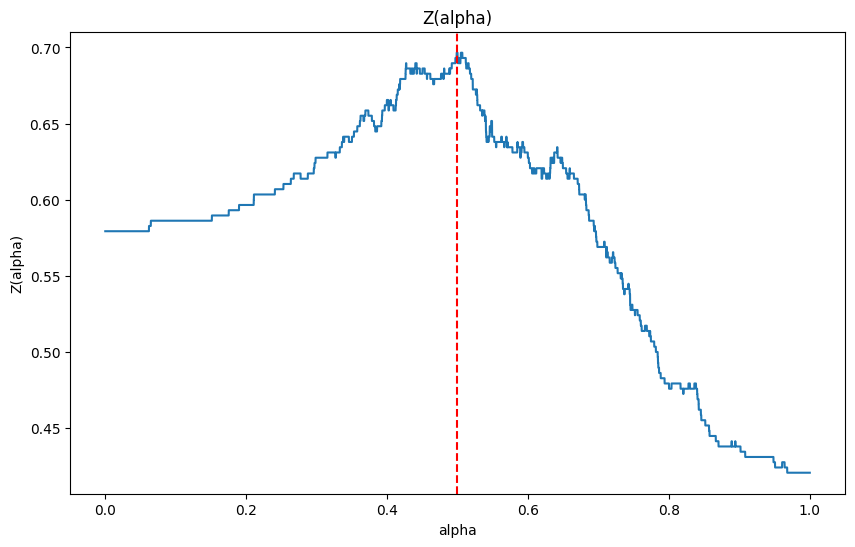

In [24]:
#| label: fig-z-alpha
#| fig-cap: "Z(alpha)"

plt.figure(figsize=(10, 6))

plt.plot(alphas, Z_list, label='Z(alpha)')
plt.axvline(x=alpha_best, color='r', linestyle='--')
plt.title('Z(alpha)')
plt.xlabel('alpha')
plt.ylabel('Z(alpha)')

The best $\alpha$ is 0.49868 with a Z score of 0.696551724137931 which is even higher than the previous one. The $\alpha$ value found is close to 0.5, initial value which makes sense because it is the one we used to compute the best subset of predictors. 

\newpage

# Question 3

We initially decided to answer all the coursework using Python. We splitted the work within the grouop each subgroup doing a question. The group doing the question 3 felt more confident using R so we decided not to "translate" it to Python. 

In [25]:
library(readxl)
library(MASS)

In [ ]:
df <- read_excel("../data/data_coursework_Q3.xlsx")

r_us <- df[["T r_$"]] / 100
r_uk <- df[["T r_£"]] / 100

In this exercise, we'll compare two models: CIR and Vasicek for US and UK 1-month interest rates using MLE estimator.

## CIR model

The CIR model postulates that $r_t$ satisfies:

$$r_t = \mu.(1-\phi)+\phi.r_{t-1} + \sqrt{r_{t-1}}.u_t$$

- $u_t \sim \mathbf{N}(0, \sigma^2)$

### Setting up MLE for CIR:
We estimate the CIR model using the Gaussian likelihood (which can be derived from the provided materials):
$$
-\ l(\theta)
= \frac12 \sum_{t=2}^T 
\left[
  \log(2\pi \sigma^2 r_{t-1})
  + \frac{\left(r_t - \mu(1-\phi) - \phi r_{t-1}\right)^2}
         {\sigma^2 r_{t-1}}
\right],
$$
which is to be minimised for optimisation.

We also calculate the conditional mean and variance.

The conditional mean is:
  $$
  E[r_t \mid r_{t-1}] = \mu(1-\phi) + \phi r_{t-1}
  $$

The conditional variance is:
$$
Var(r_t | r_{t-1}) = \sigma^2 r_{t-1}.
$$


In [27]:
# CIR Negative Log-Likelihood Function
cir_neg_loglik <- function(parameters, r) {

  mu     <- parameters[1]
  phi    <- parameters[2]
  sigma2 <- parameters[3]

  if (sigma2 <= 0) return(1e10)

  r <- as.numeric(r)
  r_t_minus_1 <- head(r, -1)
  r_t         <- tail(r, -1)

  mean_t <- mu * (1 - phi) + phi * r_t_minus_1
  var_t  <- sigma2 * r_t_minus_1

  var_t[var_t <= 1e-12] <- 1e-12

  # Computation of negtive log-likelihood
  nll <- 0.5 * sum(
    log(2 * pi * var_t) + (r_t - mean_t)^2 / var_t
  )
  return(nll)
}

## Generating reasonable initial values for optimisation:

In order to optimise (or minimize in our case) to find the MLE we need starting points. This function generates reasonable starting values for the CIR model parameters by running a simple AR(1) regression and converting the results into initial guesses for the parameters.

$\text{AR(1): } r_t = c + \phi r_{t-1} + e_t$

Using the estimated regression coefficients, we could estimate the rest of the parameters by:

$\mu = \dfrac{c}{1-\phi}, \qquad c = \mu(1-\phi)$

$\sigma^2 = \dfrac{\mathbb{E}[e_t^2]}{\mathbb{E}[r_{t-1}]}, \qquad e_t = r_t - (c + \phi r_{t-1})$

In [28]:
# Assigning initial values suitbale for the CIR model using AR(1)
cir_starting_values <- function(r) {
  r <- as.numeric(r)
    
  r_t_minus_1 <- head(r, -1)
  r_t         <- tail(r, -1)

  # AR(1) regression
  X <- cbind(1, r_t_minus_1)
  beta <- solve(t(X) %*% X) %*% (t(X) %*% r_t)
  c0   <- beta[1]
  phi0 <- beta[2]

  # if phi0 is close to 1, set mu0 to mean of r to avoid division by zero
  if (abs(1 - phi0) < 1e-6) {
    mu0 <- mean(r)
  } else {
    mu0 <- c0 / (1 - phi0)
  }

  residuals <- r_t - (c0 + phi0 * r_t_minus_1)
  eps_var <- mean(residuals^2)

  # ensure r_mean is positive to avoid division by zero
  r_mean <- max(mean(r_t_minus_1), 1e-6)
  sigma2_0 <- eps_var / r_mean

  return(c(mu0, phi0, sigma2_0))
}

We then use these initial values to start the optimisation process for maximum likelihood estimation of the CIR model parameters. In the process, L-BFGS-B method is used for optimisation.

We earlier compute $-H$ by minimizing $-l(\theta)$

We know that $\frac{I(\theta)}{T}\longrightarrow_p\mathcal{I}(\theta)$

To estimate the asymptotic covariance matrix, we use the inverse of the Hessian matrix. While the theoretical covariance is given by the inverse of $\mathcal{I}^{-1}(\theta)$, the Law of Large Numbers (LLN) allows us to approximate $\mathcal{I}(\theta)$ using the observed Hessian.

In [29]:
estimate_CIR <- function(r) {
  r <- as.numeric(r)

  theta0 <- cir_starting_values(r)

  # Setting lower and upper bounds
  lower <- c(-Inf, -0.999999999, 1e-12)
  upper <- c( Inf,  0.999999999, Inf)

  # Optimisation using L-BFGS-B method
  opt <- optim(
    par     = theta0,
    fn      = cir_neg_loglik,
    r       = r,
    method  = "L-BFGS-B",
    lower   = lower,
    upper   = upper,
    hessian = TRUE
  )

  theta_hat <- opt$par
  cov <- (tryCatch(solve(opt$hessian),
                  error = function(e) opt$hessian))  

  return(list(theta = theta_hat, cov = cov))
}

## Results for CIR:

The output below reports the estimated parameters of the short‐rate models and their corresponding asymptotic covariance matrices.

How to read the results:

- Each parameter estimate is followed by its asymptotic standard error.

- The covariance matrix is ordered as (𝜇, 𝜙, 𝜎^2) × (𝜇, 𝜙,  𝜎^2).

- A strongly persistent rate process corresponds to 𝜙 close to 1.



In [30]:
## ---- CIR: Output ----
cir_us <- estimate_CIR(r_us)
cir_uk <- estimate_CIR(r_uk)

mu_us     <- cir_us$theta[1]
phi_us    <- cir_us$theta[2]
sigma2_us <- cir_us$theta[3]

mu_uk     <- cir_uk$theta[1]
phi_uk    <- cir_uk$theta[2]
sigma2_uk <- cir_uk$theta[3]

cat("===== CIR Model (US) =====\n")
print(c(mu=mu_us, phi=phi_us, sigma2=sigma2_us))
print(cir_us$cov)

cat("\n===== CIR Model (UK) =====\n")
print(c(mu=mu_uk, phi=phi_uk, sigma2=sigma2_uk))
print(cir_uk$cov)

===== CIR Model (US) =====
          mu          phi       sigma2 
0.0588978437 0.9847629119 0.0007824392 
             [,1]         [,2]         [,3]
[1,] 6.743617e-03 2.806139e-03 1.606430e-14
[2,] 2.806139e-03 1.265233e-03 8.160818e-15
[3,] 1.606428e-14 8.160811e-15 3.999999e-16

===== CIR Model (UK) =====
          mu          phi       sigma2 
0.0810004460 0.9929480603 0.0002809132 
              [,1]         [,2]          [,3]
[1,]  1.580686e-03 1.143380e-04 -6.669003e-17
[2,]  1.143380e-04 6.477717e-05  1.572494e-16
[3,] -6.669003e-17 1.572494e-16  3.999999e-16


We have surprisingly big variance for mu and phi which can be explained by 

## Setting up for the Vasicek Model:

$$ r_t = \mu(1-\phi) + \phi r_{t-1} + u_t,\qquad u_t \sim NID(0,\sigma^2) $$

For the Vasicek model, we follow an almost identical estimation procedure, as several components of the likelihood and optimisation steps are shared with the CIR case. For clarity and readability, we present the full workflow again below.

Again, we use AR(1) for a rigourous generation of the starting values.

In [31]:
# Simiarly, we define the negative log-likelihood for the Vasicek model.
vasicek_neg_loglik <- function(parameters, r) {
  mu     <- parameters[1]
  phi    <- parameters[2]
  sigma2 <- parameters[3]

  # sigma^2 must be positive
  if (sigma2 <= 0) return(1e10)

  if (abs(phi) >= 1) return(1e10)

  r <- as.numeric(r)
  r_t_minus_1 <- head(r, -1)
  r_t         <- tail(r, -1)

  # Conditional mean and variance
  mean_t <- mu * (1 - phi) + phi * r_t_minus_1
  var_t  <- sigma2

  # Negtive log-likelihood
  nll <- 0.5 * sum(
    log(2 * pi * var_t) + (r_t - mean_t)^2 / var_t
  )
  return(nll)
}
vasicek_starting_values <- function(r) {
  r <- as.numeric(r)
  r_t_minus_1 <- head(r, -1)
  r_t         <- tail(r, -1)

  X <- cbind(1, r_t_minus_1)
  beta <- solve(t(X) %*% X) %*% (t(X) %*% r_t)
  c0   <- beta[1]
  phi0 <- beta[2]

  # # Back-calculate mu0 from c0, phi0 (same as CIR)
  if (abs(1 - phi0) < 1e-6) {
    mu0 <- mean(r)
  } else {
    mu0 <- c0 / (1 - phi0)
  }

  # Residual variance ≈ sigma^2
  residuals <- r_t - (c0 + phi0 * r_t_minus_1)
  sigma2_0  <- var(residuals)

  return(c(mu0, phi0, sigma2_0))
}

In [32]:
estimate_Vasicek_MLE <- function(r) {
  r <- as.numeric(r)

  theta0 <- vasicek_starting_values(r)

  # Setting lower and upper bounds
  lower <- c(-Inf, -0.999999999, 1e-12)
  upper <- c( Inf,  0.999999999, Inf)

  opt <- optim(
    par     = theta0,
    fn      = vasicek_neg_loglik,
    r       = r,
    method  = "L-BFGS-B",
    lower   = lower,
    upper   = upper,
    hessian = TRUE
  )

  theta_hat <- opt$par
  vcov <- tryCatch(
    solve(opt$hessian),
    error = function(e) matrix(NA_real_, 3, 3)
  )

  return(list(
    theta  = setNames(theta_hat, c("mu", "phi", "sigma2")),
    cov    = vcov,
    loglik = -opt$value
  ))
}

In [33]:
# Vasicek Output
vas_us <- estimate_Vasicek_MLE(r_us)
vas_uk <- estimate_Vasicek_MLE(r_uk)

mu_v_us     <- vas_us$theta[1]
phi_v_us    <- vas_us$theta[2]
sigma2_v_us <- vas_us$theta[3]

mu_v_uk     <- vas_uk$theta[1]
phi_v_uk    <- vas_uk$theta[2]
sigma2_v_uk <- vas_uk$theta[3]

cat("===== Vasicek MLE (US) =====\n")
print(c(mu_v_us, phi_v_us, sigma2_v_us))
print(vas_us$cov)

cat("\n===== Vasicek MLE (UK) =====\n")
print(c(mu_v_uk, phi_v_uk, sigma2_v_uk))
print(vas_uk$cov)

===== Vasicek MLE (US) =====
          mu          phi       sigma2 
5.889784e-02 9.847629e-01 5.618916e-05 
              [,1]          [,2]          [,3]
[1,]  8.589483e-04 -1.029690e-04  1.523298e-26
[2,] -1.029690e-04  1.236800e-04 -2.458972e-27
[3,]  1.523298e-26 -2.458972e-27  3.999999e-16

===== Vasicek MLE (UK) =====
          mu          phi       sigma2 
8.100045e-02 9.929481e-01 2.592955e-05 
              [,1]          [,2]          [,3]
[1,]  1.810373e-03 -9.258096e-05 -3.402991e-26
[2,] -9.258096e-05  5.930304e-05  3.601377e-27
[3,] -3.402991e-26  3.601377e-27  3.999999e-16


## Analysis

- We can see that the parameters $\phi$ and $\mu$ are identical for both models. The Vasicek and CIR outputs suggests that the estimation of the "location" (mean) and the "speed" (reversion) of the rates is robust. The choice of volatility structure (homoscedastic vs. heteroscedastic) has not biased the drift estimation.

- Both the US and UK short-term interest rates exhibit strong persistence, with estimated 𝜙 close to 1 under both models. $\phi$ is bigger for UK interest rates than US which implies that shocks to the UK economy (unexpected rate changes) tend to have a longer-lasting impact on the interest rate trajectory than similar shocks in the US economy. 

- The US has a lower estimated long-run short rate than the UK under both models.

- A key difference between CIR and Vasicek is how volatility depends on the level of the short rate.
    - Vasicek assumes constant volatility.
    - CIR allows volatility to scale with the interest rate.
    
- In our research: For the UK, volatility is notably lower and rates are higher, suggesting the simple Vasicek model approximates the dynamics quite well as the probability of negative rates is negligible.For the US, variability is higher, making the CIR model's feature of level-dependent volatility potentially more relevant for capturing risk, despite both models estimating similar drift trends